In [24]:
import tushare as ts
import seaborn as sns
import keras
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.optimizers import RMSprop
from keras.initializers import Orthogonal
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
set_matplotlib_formats('retina')

In [2]:
ts.set_token('53cd3b985c649c978160c6ec04bce24f4fbd2ebcb4673e8f2fba9a43')

pro = ts.pro_api()

code_df = pro.stock_basic(exchange='', list_status='L', fields='ts_code')

C:\Users\GreenWood\Anaconda3\envs\tf_gpu_keras\lib\site-packages\tushare\util\upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [3]:
code_df.head()

,ts_code
0,000001.SZ
1,000002.SZ
2,000004.SZ
3,000005.SZ
4,000006.SZ


In [4]:
code_df.values.shape

(3664, 1)

In [5]:
pledge = pd.read_csv('data/pledge_clean.csv', index_col=0)
pledge['close_position_date'] = pd.to_datetime(pledge['close_position_date'])
pledge['pledge_date'] = pd.to_datetime(pledge['pledge_date'])

In [6]:
pledge = pledge.sort_values(by=['close_position_date'])
pledge = pledge.reset_index(drop=True)

In [7]:
pledge.head(10)

,code,pledge_date,alarm_line,close_position_line,price_on_pledge,total_pledge_nb,total_share_ratio,total_stock_ratio,close_position_date,is_st
0,002280.SZ,2016-03-30,16.13,14.12,25.21,4471.250000,39.53000,2.050000,2016-12-14,0
1,002280.SZ,2016-03-30,16.13,14.12,25.21,4471.250000,39.53000,2.050000,2016-12-14,0
2,002280.SZ,2016-03-30,16.13,14.12,25.21,4471.250000,39.53000,2.050000,2016-12-14,0
3,000796.SZ,2016-03-09,17.42,15.24,27.22,25525.720000,100.00000,31.790000,2016-12-20,0
4,000796.SZ,2016-01-18,17.42,15.24,27.22,23525.720000,92.16000,29.300000,2016-12-20,0
5,000796.SZ,2016-04-28,17.42,15.24,27.22,37910.007785,82.15942,18.559834,2016-12-20,0
6,000796.SZ,2016-04-28,17.42,15.24,27.22,37910.007785,82.15942,18.559834,2016-12-20,0
7,002147.SZ,2016-12-05,18.03,15.77,28.17,30280.580000,97.83000,34.080000,2017-01-16,0
8,000503.SZ,2016-12-01,37.08,32.44,57.93,4214.180000,17.88000,4.690000,2017-04-12,0
9,000503.SZ,2016-12-07,34.50,30.18,53.90,17629.000000,70.97000,19.610000,2017-05-09,0


In [8]:
code_price_dict = dict()
for i in range(len(code_df)):
    code = code_df.iloc[i, 0]
    price_df = pd.read_csv('data/price/{}.csv'.format(code), index_col=0)
    price_df.index = pd.to_datetime(price_df.index)
    code_price_dict[code] = price_df

In [9]:
def get_stock_price_by_code(code, lookback, delay, pledge_date, close_position_date, code_price_dict, pledge_price):
    """
    通过股票代码，过去天数，生成三维的股票价格矩阵
    delay * lookback * 9(features)
    """
    scaler = MinMaxScaler()
    non_close_rate = 4
    price_df = code_price_dict[code]
    price_df['delta'] = price_df.apply(lambda x: x['close'] - pledge_price, axis=1)
    price_df = price_df[pledge_date: close_position_date]
    price_values = price_df.values
    # 平仓训练集
    usable_close_len = len(price_df) - lookback
    usable_close_len = min(usable_close_len, delay + 1)
    close_list = []
    for i in range(1, usable_close_len + 1):
        price_time = price_values[-lookback - i: -i]
        close_list.append(scaler.fit_transform(price_time))
    # 正常训练集
    usable_non_close_len = len(price_df) - delay - lookback
    usable_non_close_len = min(usable_non_close_len, non_close_rate * delay)
    non_close_list = []
    for i in range(delay+1, delay+1+usable_non_close_len):
        price_time = price_values[-lookback - i: -i]
        non_close_list.append(scaler.fit_transform(price_time))
        
    return close_list, non_close_list

In [10]:
pledge.drop(['code', 'pledge_date', 'close_position_date'], axis=1).head()

,alarm_line,close_position_line,price_on_pledge,total_pledge_nb,total_share_ratio,total_stock_ratio,is_st
0,16.13,14.12,25.21,4471.25,39.53,2.05,0
1,16.13,14.12,25.21,4471.25,39.53,2.05,0
2,16.13,14.12,25.21,4471.25,39.53,2.05,0
3,17.42,15.24,27.22,25525.72,100.00,31.79,0
4,17.42,15.24,27.22,23525.72,92.16,29.30,0


In [11]:
def generator(pledge, lookback, delay, min_index, max_index, code_price_dict):
    # batch_size == delay(30)
    i = min_index
    all_zip = []
    # 归一化
    scaler = MinMaxScaler()
    pledge_scaled = pledge.drop(['code', 'pledge_date', 'close_position_date'], axis=1)
    pledge_scaled = scaler.fit_transform(pledge_scaled)
    while i < max_index:
        single_pledge = pledge.loc[i]
        single_pledge_scaled = pledge_scaled[i]
        close_list, non_close_list = get_stock_price_by_code(code=single_pledge['code'],
                               lookback=lookback,
                               delay=delay,
                               pledge_date=single_pledge['pledge_date'],
                               close_position_date=single_pledge['close_position_date'],
                               code_price_dict=code_price_dict,
                               pledge_price=single_pledge['price_on_pledge'])
        close_zip = [(prices, single_pledge_scaled, 1) for prices in close_list]
        non_close_zip = [(prices, single_pledge_scaled, 0) for prices in non_close_list]
        all_zip += close_zip + non_close_zip
        i += 1
    random.shuffle(all_zip)
    price_time = np.stack([t[0] for t in all_zip])
    pledge_info = np.stack([t[1] for t in all_zip])
    targets = np.stack([t[2] for t in all_zip])
    
    return price_time, pledge_info, targets

In [61]:
lookback = 48
delay = 30

train_price, train_info, train_targets = generator(pledge, lookback, delay, 0, 800, code_price_dict)
test_price, test_info, test_targets = generator(pledge, lookback, delay, 800, len(pledge), code_price_dict)

In [53]:
train_info.shape

(80336, 7)

In [54]:
train_price.shape

(80336, 64, 10)

In [38]:
def show_ratio(targets):
    unique, counts = np.unique(targets, return_counts=True)
    d = dict(zip(unique, counts))
    print(d)
    print(d[0] / (d[0] + d[1]))

In [62]:
show_ratio(train_targets)

{0: 64521, 1: 22102}
0.744848365907438


In [63]:
show_ratio(test_targets)

{0: 12396, 1: 4435}
0.736498128453449


In [70]:
def get_model(time_steps, price_dim, info_dim):
    price_input = Input(shape=(time_steps, price_dim), name='price_input')
#     lstm_out = LSTM(32, 
#                     dropout=0.2,
#                     recurrent_dropout=0.5, 
#                     kernel_initializer=Orthogonal(seed=7)
#                    )(price_input)
    tcn_out = TCN(nb_filters=64, 
            kernel_size=3, 
            dilations=[1, 2, 4, 8, 16], 
            nb_stacks=1, 
            dropout_rate=0.3,
            kernel_initializer=Orthogonal(seed=7),
            use_skip_connections=True,
            return_sequences=False)(price_input)
    info_input = Input(shape=(info_dim,), name='info_input')
    x = keras.layers.concatenate([tcn_out, info_input])
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[price_input, info_input], outputs=[output])
    return model

In [71]:
model = get_model(time_steps=lookback, price_dim=train_price.shape[-1], info_dim=train_info.shape[-1])
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
price_input (InputLayer)        (None, 48, 10)       0                                            
__________________________________________________________________________________________________
conv1d_154 (Conv1D)             (None, 48, 64)       704         price_input[0][0]                
__________________________________________________________________________________________________
conv1d_155 (Conv1D)             (None, 48, 64)       12352       conv1d_154[0][0]                 
__________________________________________________________________________________________________
activation_145 (Activation)     (None, 48, 64)       0           conv1d_155[0][0]                 
__________________________________________________________________________________________________
spatial_dr

In [72]:
history = model.fit([train_price, train_info], 
          train_targets, 
          epochs=3, 
          batch_size=64,
          validation_data=([test_price, test_info], test_targets))

Train on 86623 samples, validate on 16831 samples
Epoch 1/3
86623/86623 [==============================] - 37s 428us/step - loss: 0.5451 - acc: 0.7454 - val_loss: 0.5674 - val_acc: 0.7257
Epoch 2/3
86623/86623 [==============================] - 34s 390us/step - loss: 0.4971 - acc: 0.7711 - val_loss: 0.5339 - val_acc: 0.7502
Epoch 3/3
86623/86623 [==============================] - 34s 390us/step - loss: 0.4655 - acc: 0.7891 - val_loss: 0.5161 - val_acc: 0.7610


In [33]:
def plot_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

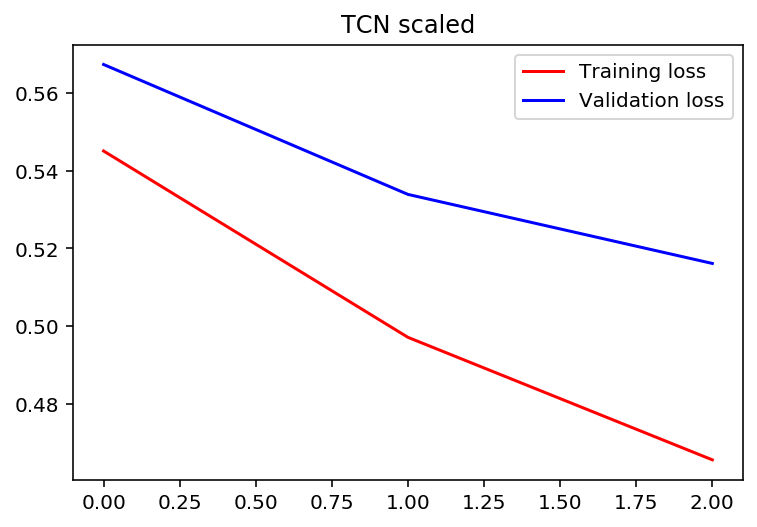

In [73]:
plot_loss(history, 'TCN scaled')

In [74]:
from sklearn.metrics import roc_auc_score
y_predict = model.predict([test_price, test_info])
roc_auc_score(test_targets, y_predict)

0.7219226444287044